# Random Forest run
Total dataset size: 127 samples <br>
Training set: 95 samples <br>
Testing set: 32 samples

Features used:
- LTA precipitation (mmpa)
- LTA WD (days)
- LTA PET (mm)
- Aridity idx
- LTA NDVI idx
- LTA soil moisture - 10cm (kgm-2)
- Aquifer group (cat.)
- Soil group (cat.)
- Landcover (cat.)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates

# read file (data + coordinates)
file = pd.read_csv('Data/Low_res_data_05/input_05_ext.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa'] < 800]
# drop unimportant columns
data = file.drop(columns=['Lat', 'Long', 'LTA_WD_days', 'Aquifer_group', 'Soil_group', 'Landcover', 'Landcover_NOAA', 'Landcover_GlobCover', 'DEM'])
data

,Recharge_mmpa,LTA_CHIRPS_mmpa,LTA_GPCC_mmpa,LTA_P_mmpa,LTA_PET_mm,Aridity,NDVI,SM10_m3m3,SM10_kgm2,ID
0,253.0,1215.759255,1103.60340,1234.743356,1265.000000,0.977426,0.548899,0.317942,23.815275,1
1,22.0,475.869821,555.43835,555.876675,1386.030028,0.403442,0.417538,0.210401,17.259396,2
2,245.0,1267.350207,1341.60230,1376.716688,1337.440024,1.029575,0.687945,0.312940,26.114550,3
3,185.0,482.137867,608.88070,518.196676,1590.610029,0.326188,0.268559,0.229384,19.132140,4
4,120.0,1310.878963,1120.90340,1344.580024,1298.693353,1.038857,0.593882,0.330358,25.831575,5
...,...,...,...,...,...,...,...,...,...,...
129,100.0,611.063066,669.56696,655.280013,1356.070025,0.486649,0.403724,0.323871,22.159473,130
130,80.0,787.538745,753.93494,816.720013,1266.233355,0.648767,0.479056,0.227937,19.953318,131
131,8.0,482.529637,467.50770,510.140009,1922.536704,0.265403,0.327490,0.194245,11.226820,132
132,160.0,1010.916120,1053.96100,1215.073356,1149.026683,1.058098,0.447078,0.279276,29.116320,133


,mean,std
BGS CRU,615.824446,402.775498
CHIRPS,593.161588,413.192502
GPCC,618.816062,399.035294


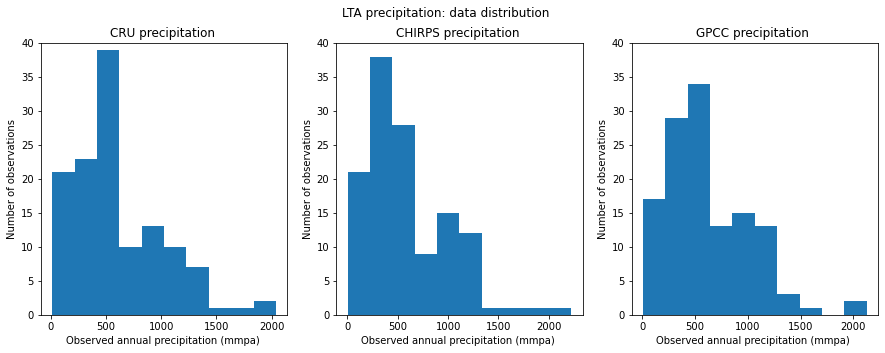

In [2]:
n_bins = 10

fig, axs = plt.subplots(1,3, figsize=(15,5))
axs = axs.flatten()
fig.suptitle("LTA precipitation: data distribution")
# We can set the number of bins with the `bins` kwarg
axs[0].hist(data['LTA_P_mmpa'], bins=n_bins)
axs[0].set_title('CRU precipitation ')
axs[0].set_xlabel('Observed annual precipitation (mmpa) ')
axs[0].set_ylabel('Number of observations')
axs[0].set_ylim(0,40)

axs[1].hist(data['LTA_CHIRPS_mmpa'], bins=n_bins)
axs[1].set_title('CHIRPS precipitation ')
axs[1].set_xlabel('Observed annual precipitation (mmpa) ')
axs[1].set_ylabel('Number of observations')
axs[1].set_ylim(0,40)

axs[2].hist(data['LTA_GPCC_mmpa'], bins=n_bins)
axs[2].set_title('GPCC precipitation ')
axs[2].set_xlabel('Observed annual precipitation (mmpa) ')
axs[2].set_ylabel('Number of observations')
axs[2].set_ylim(0,40)

means = [np.mean(data['LTA_P_mmpa']), np.mean(data['LTA_CHIRPS_mmpa']), np.mean(data['LTA_GPCC_mmpa'])]
stds = [np.std(data['LTA_P_mmpa']), np.std(data['LTA_CHIRPS_mmpa']), np.std(data['LTA_GPCC_mmpa'])]

pd.DataFrame({'mean': means, 'std': stds }, index=['BGS CRU', 'CHIRPS', 'GPCC'])

,mean,std
FLDAS,0.230326,0.049859
GLDAS,17.060524,5.701569


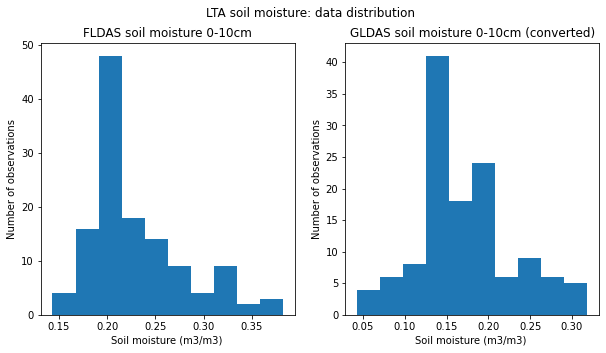

In [3]:
n_bins = 10

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs = axs.flatten()
fig.suptitle("LTA soil moisture: data distribution")
# We can set the number of bins with the `bins` kwarg
axs[0].hist(data['SM10_m3m3'], bins=n_bins)
axs[0].set_title('FLDAS soil moisture 0-10cm')
axs[0].set_xlabel('Soil moisture (m3/m3) ')
axs[0].set_ylabel('Number of observations')

# axs[1].hist(data['SM10_kgm2'], bins=n_bins)
# axs[1].set_title('GLDAS soil moisture 0-10cm ')
# axs[1].set_xlabel('Soil moisture (kg/m2) ')
# axs[1].set_ylabel('Number of observations')

c = data['SM10_kgm2'] / 100
axs[1].hist(c, bins=n_bins)
axs[1].set_title('GLDAS soil moisture 0-10cm (converted)')
axs[1].set_xlabel('Soil moisture (m3/m3) ')
axs[1].set_ylabel('Number of observations')

means = [np.mean(data['SM10_m3m3']), np.mean(data['SM10_kgm2'])]
stds = [np.std(data['SM10_m3m3']), np.std(data['SM10_kgm2'])]

pd.DataFrame({'mean': means, 'std': stds }, index=['FLDAS', 'GLDAS'])

In [4]:
# Labels are the values we want to predict
labels = np.log10(data['Recharge_mmpa'])
# Remove the labels from the features
data = data.drop('Recharge_mmpa', axis = 1)
# Add for reference
data['ID'] = file['ID']
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

## Run 100 random forests for each option

In [5]:
data = { 'base_train': [], 'base_test': [], 'chirps_train':[], 'chirps_test':[], 'gpcc_train':[], 'gpcc_test':[], 'gldas_train':[], 'gldas_test':[]}
params = {'n_estimators': 2000}

for i in range(0,101):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)    

    # isolate the features
    base_train_features = np.delete(train_features,obj=[0,1,7], axis=1)
    gpcc_train_features = np.delete(train_features,obj=[0,2,7], axis=1)
    chirps_train_features = np.delete(train_features,obj=[1,2,7], axis=1)
    base_test_features = np.delete(test_features,obj=[0,1,7], axis=1)
    gpcc_test_features = np.delete(test_features,obj=[0,2,7], axis=1)
    chirps_test_features = np.delete(test_features,obj=[1,2,7], axis=1)
    
    gldas_train_features = np.delete(train_features,obj=[0,1,6], axis=1)
    gldas_test_features = np.delete(test_features,obj=[0,1,6], axis=1)
    
    # Instantiate models
    rf_base = RandomForestRegressor(**params, oob_score=True, random_state=i)
    rf_chirps = RandomForestRegressor(**params, oob_score=True, random_state=i)
    rf_gpcc = RandomForestRegressor(**params, oob_score=True, random_state=i)
    rf_gldas = RandomForestRegressor(**params, oob_score=True, random_state=i)

    # Train the model on training data
    rf_base.fit(base_train_features[:,:-1], train_labels)
    rf_chirps.fit(gpcc_train_features[:,:-1], train_labels)
    rf_gpcc.fit(gpcc_train_features[:,:-1], train_labels)
    rf_gldas.fit(gldas_train_features[:,:-1], train_labels)

    # Use the forest's predict method on the test data
    base_predictions = rf_base.predict(base_test_features[:,:-1])
    chirps_predictions = rf_chirps.predict(chirps_test_features[:,:-1])
    gpcc_predictions = rf_gpcc.predict(gpcc_test_features[:,:-1])
    gldas_predictions = rf_gldas.predict(gldas_test_features[:,:-1])

    # Use the forest's predict method on the training data
    base_train_predictions = rf_base.predict(base_train_features[:,:-1])
    chirps_train_predictions = rf_chirps.predict(chirps_train_features[:,:-1])
    gpcc_train_predictions = rf_gpcc.predict(gpcc_train_features[:,:-1])
    gldas_train_predictions = rf_gldas.predict(gldas_train_features[:,:-1])
    
    print(f'[BASE] Out-of-bag score: {rf_base.oob_score_:>5.3}; Train R-2: {metrics.r2_score(train_labels, base_train_predictions)}; Test R-2: {metrics.r2_score(test_labels, base_predictions)}')
    print(f'[CHIRPS] Out-of-bag score: {rf_chirps.oob_score_:>5.3}; Train R-2: {metrics.r2_score(train_labels, chirps_train_predictions)}; Test R-2: {metrics.r2_score(test_labels, base_predictions)}')
    print(f'[GPCC] Out-of-bag score: {rf_gpcc.oob_score_:>5.3}; Train R-2: {metrics.r2_score(train_labels, gpcc_train_predictions)}; Test R-2: {metrics.r2_score(test_labels, gpcc_predictions)}')
    print(f'[GLDAS] Out-of-bag score: {rf_gldas.oob_score_:>5.3}; Train R-2: {metrics.r2_score(train_labels, gldas_train_predictions)}; Test R-2: {metrics.r2_score(test_labels, gldas_predictions)}')

    data['base_train'].append(rf_base.score(base_train_features[:,:-1], train_labels))
    data['base_test'].append(rf_base.score(base_test_features[:,:-1], test_labels))
    data['chirps_train'].append(rf_chirps.score(chirps_train_features[:,:-1], train_labels))
    data['chirps_test'].append(rf_chirps.score(chirps_test_features[:,:-1], test_labels))
    data['gpcc_train'].append(rf_gpcc.score(gpcc_train_features[:,:-1], train_labels))
    data['gpcc_test'].append(rf_gpcc.score(gpcc_test_features[:,:-1], test_labels))
    data['gldas_train'].append(rf_gldas.score(gldas_train_features[:,:-1], train_labels))
    data['gldas_test'].append(rf_gldas.score(gldas_test_features[:,:-1], test_labels))

[BASE] Out-of-bag score: 0.553; Train R-2: 0.9307133732069666; Test R-2: 0.7677646302313011
[CHIRPS] Out-of-bag score: 0.625; Train R-2: 0.8259900046835528; Test R-2: 0.7677646302313011
[GPCC] Out-of-bag score: 0.625; Train R-2: 0.9402136986793856; Test R-2: 0.7806419177172907
[GLDAS] Out-of-bag score: 0.521; Train R-2: 0.925187321881286; Test R-2: 0.7609546386724844
[BASE] Out-of-bag score:  0.68; Train R-2: 0.9533960571324182; Test R-2: 0.4093943150273206
[CHIRPS] Out-of-bag score: 0.724; Train R-2: 0.8439984359971333; Test R-2: 0.4093943150273206
[GPCC] Out-of-bag score: 0.724; Train R-2: 0.9593946292062239; Test R-2: 0.5108533655584838
[GLDAS] Out-of-bag score: 0.639; Train R-2: 0.9471125584357838; Test R-2: 0.45821540910511716
[BASE] Out-of-bag score: 0.638; Train R-2: 0.9471827774855991; Test R-2: 0.6157961666751348
[CHIRPS] Out-of-bag score:  0.71; Train R-2: 0.8226683491766886; Test R-2: 0.6157961666751348
[GPCC] Out-of-bag score:  0.71; Train R-2: 0.9570070348996365; Test R-2:

[BASE] Out-of-bag score: 0.647; Train R-2: 0.9451937927010026; Test R-2: 0.616264797632048
[CHIRPS] Out-of-bag score: 0.664; Train R-2: 0.8703857959989652; Test R-2: 0.616264797632048
[GPCC] Out-of-bag score: 0.664; Train R-2: 0.9474298792162695; Test R-2: 0.6790746417712628
[GLDAS] Out-of-bag score:  0.63; Train R-2: 0.9430491965333447; Test R-2: 0.5892273790790583
[BASE] Out-of-bag score: 0.623; Train R-2: 0.9465176641570143; Test R-2: 0.691521336123027
[CHIRPS] Out-of-bag score: 0.667; Train R-2: 0.8496797516252357; Test R-2: 0.691521336123027
[GPCC] Out-of-bag score: 0.667; Train R-2: 0.9523133076842025; Test R-2: 0.7522738715773583
[GLDAS] Out-of-bag score: 0.609; Train R-2: 0.944418788220016; Test R-2: 0.6593185173255305
[BASE] Out-of-bag score: 0.579; Train R-2: 0.9336688267950982; Test R-2: 0.7607978410035887
[CHIRPS] Out-of-bag score: 0.636; Train R-2: 0.8301771274940856; Test R-2: 0.7607978410035887
[GPCC] Out-of-bag score: 0.636; Train R-2: 0.9412095423548021; Test R-2: 0.76

[BASE] Out-of-bag score: 0.603; Train R-2: 0.9427434011601146; Test R-2: 0.6638504249135195
[CHIRPS] Out-of-bag score: 0.654; Train R-2: 0.8432544375515202; Test R-2: 0.6638504249135195
[GPCC] Out-of-bag score: 0.654; Train R-2: 0.9493484887691063; Test R-2: 0.6849632129982898
[GLDAS] Out-of-bag score:   0.6; Train R-2: 0.9413317163395706; Test R-2: 0.6254594478504996
[BASE] Out-of-bag score: 0.632; Train R-2: 0.9491808714384665; Test R-2: 0.6558517654987059
[CHIRPS] Out-of-bag score: 0.687; Train R-2: 0.8634017910260494; Test R-2: 0.6558517654987059
[GPCC] Out-of-bag score: 0.687; Train R-2: 0.9566411362570548; Test R-2: 0.681801093830009
[GLDAS] Out-of-bag score: 0.623; Train R-2: 0.9478354263886651; Test R-2: 0.6424893338634536
[BASE] Out-of-bag score: 0.658; Train R-2: 0.9490036654784616; Test R-2: 0.655277612424338
[CHIRPS] Out-of-bag score: 0.689; Train R-2: 0.863601717482933; Test R-2: 0.655277612424338
[GPCC] Out-of-bag score: 0.689; Train R-2: 0.9529693807353592; Test R-2: 0.6

[BASE] Out-of-bag score: 0.671; Train R-2: 0.9498714953376854; Test R-2: 0.6039676543277278
[CHIRPS] Out-of-bag score: 0.676; Train R-2: 0.8715778048071751; Test R-2: 0.6039676543277278
[GPCC] Out-of-bag score: 0.676; Train R-2: 0.950888798413972; Test R-2: 0.686538543873475
[GLDAS] Out-of-bag score: 0.656; Train R-2: 0.9480223649316942; Test R-2: 0.573580040929677
[BASE] Out-of-bag score: 0.693; Train R-2: 0.9525223325597563; Test R-2: 0.3812600042752715
[CHIRPS] Out-of-bag score: 0.728; Train R-2: 0.8581156526719859; Test R-2: 0.3812600042752715
[GPCC] Out-of-bag score: 0.728; Train R-2: 0.957007168380384; Test R-2: 0.4723666817825867
[GLDAS] Out-of-bag score: 0.662; Train R-2: 0.9481762525753071; Test R-2: 0.4026032293950724
[BASE] Out-of-bag score: 0.723; Train R-2: 0.9614796069774509; Test R-2: 0.3527368198120163
[CHIRPS] Out-of-bag score:  0.73; Train R-2: 0.9126104027939945; Test R-2: 0.3527368198120163
[GPCC] Out-of-bag score:  0.73; Train R-2: 0.9623256407218754; Test R-2: 0.5

[BASE] Out-of-bag score: 0.669; Train R-2: 0.949454674082543; Test R-2: 0.5034787720983847
[CHIRPS] Out-of-bag score: 0.714; Train R-2: 0.8910884944427965; Test R-2: 0.5034787720983847
[GPCC] Out-of-bag score: 0.714; Train R-2: 0.9554917286973882; Test R-2: 0.5273251609150337
[GLDAS] Out-of-bag score: 0.664; Train R-2: 0.9486883619181024; Test R-2: 0.5118307692074056
[BASE] Out-of-bag score: 0.671; Train R-2: 0.9537748725610279; Test R-2: 0.5455264721517117
[CHIRPS] Out-of-bag score:  0.68; Train R-2: 0.8846751729001131; Test R-2: 0.5455264721517117
[GPCC] Out-of-bag score:  0.68; Train R-2: 0.9549037117752666; Test R-2: 0.641380016885575
[GLDAS] Out-of-bag score: 0.662; Train R-2: 0.9517887032616564; Test R-2: 0.5335610671661963
[BASE] Out-of-bag score: 0.611; Train R-2: 0.9406152500921804; Test R-2: 0.6487957663586431
[CHIRPS] Out-of-bag score: 0.686; Train R-2: 0.8316699797683947; Test R-2: 0.6487957663586431
[GPCC] Out-of-bag score: 0.686; Train R-2: 0.9506343290738193; Test R-2: 0

### Mean statistics

In [6]:
base_train_mean = np.mean(data['base_train'])
base_test_mean = np.mean(data['base_test'])
chirps_train_mean = np.mean(data['chirps_train'])
chirps_test_mean = np.mean(data['chirps_test'])
gpcc_train_mean = np.mean(data['gpcc_train'])
gpcc_test_mean = np.mean(data['gpcc_test'])
gldas_train_mean = np.mean(data['gldas_train'])
gldas_test_mean = np.mean(data['gldas_test'])
print(f"+++ CRU precipitation + FLDAS soil moisture based RF +++ train R2:{base_train_mean}, test R2: {base_test_mean}")
print(f"+++ CHIRPS precipitation based RF +++ train R2:{chirps_train_mean}, test R2: {chirps_test_mean}")
print(f"+++ GPCC precipitation based RF +++ train R2:{gpcc_train_mean}, test R2: {gpcc_test_mean}")
print(f"+++ CRU precipitation + GLDAS soil moisture based RF +++ train R2:{gldas_train_mean}, test R2: {gldas_test_mean}")

+++ CRU precipitation + FLDAS soil moisture based RF +++ train R2:0.9454035591390432, test R2: 0.6162825295969805
+++ CHIRPS precipitation based RF +++ train R2:0.8535390077551434, test R2: 0.6162668661074135
+++ GPCC precipitation based RF +++ train R2:0.951231026277882, test R2: 0.6627995179212601
+++ CRU precipitation + GLDAS soil moisture based RF +++ train R2:0.9432734517677175, test R2: 0.603333467334929


### Last run: statistics

In [20]:
# training set metrics
print('=== BASE DATA ::::: Prediction of training set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(train_labels, base_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, base_train_predictions))
print('Max Error:', metrics.max_error(train_labels, base_train_predictions))
print('R^2:', metrics.r2_score(train_labels, base_train_predictions))
# training set metrics
print('=== CHIRPS DATA ::::: Prediction of training set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(train_labels, chirps_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, chirps_train_predictions))
print('Max Error:', metrics.max_error(train_labels, chirps_train_predictions))
print('R^2:', metrics.r2_score(train_labels, chirps_train_predictions))
# training set metrics
print('=== GPCC DATA ::::: Prediction of training set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(train_labels, gpcc_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, gpcc_train_predictions))
print('Max Error:', metrics.max_error(train_labels, gpcc_train_predictions))
print('R^2:', metrics.r2_score(train_labels, gpcc_train_predictions))
# training set metrics
print('=== GLDAS DATA ::::: Prediction of training set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(train_labels, gldas_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(train_labels, gldas_train_predictions))
print('Max Error:', metrics.max_error(train_labels, gldas_train_predictions))
print('R^2:', metrics.r2_score(train_labels, gldas_train_predictions))

=== BASE DATA ::::: Prediction of training set ===
Root Mean Squared Error (RMSE): 0.17538034930332477
Explained Variance Score: 0.9429666565583766
Max Error: 0.5092298176309866
R^2: 0.9429574357088304
=== CHIRPS DATA ::::: Prediction of training set ===
Root Mean Squared Error (RMSE): 0.28138068138384326
Explained Variance Score: 0.8586999268430346
Max Error: 0.9477329140190824
R^2: 0.85316630319986
=== GPCC DATA ::::: Prediction of training set ===
Root Mean Squared Error (RMSE): 0.1693665812230878
Explained Variance Score: 0.9468039572327587
Max Error: 0.4991503439628181
R^2: 0.9468023287490873
=== GLDAS DATA ::::: Prediction of training set ===
Root Mean Squared Error (RMSE): 0.17966452507600048
Explained Variance Score: 0.9401416423293414
Max Error: 0.5108216544912483
R^2: 0.940136535601565


(-300.0, 300.0)

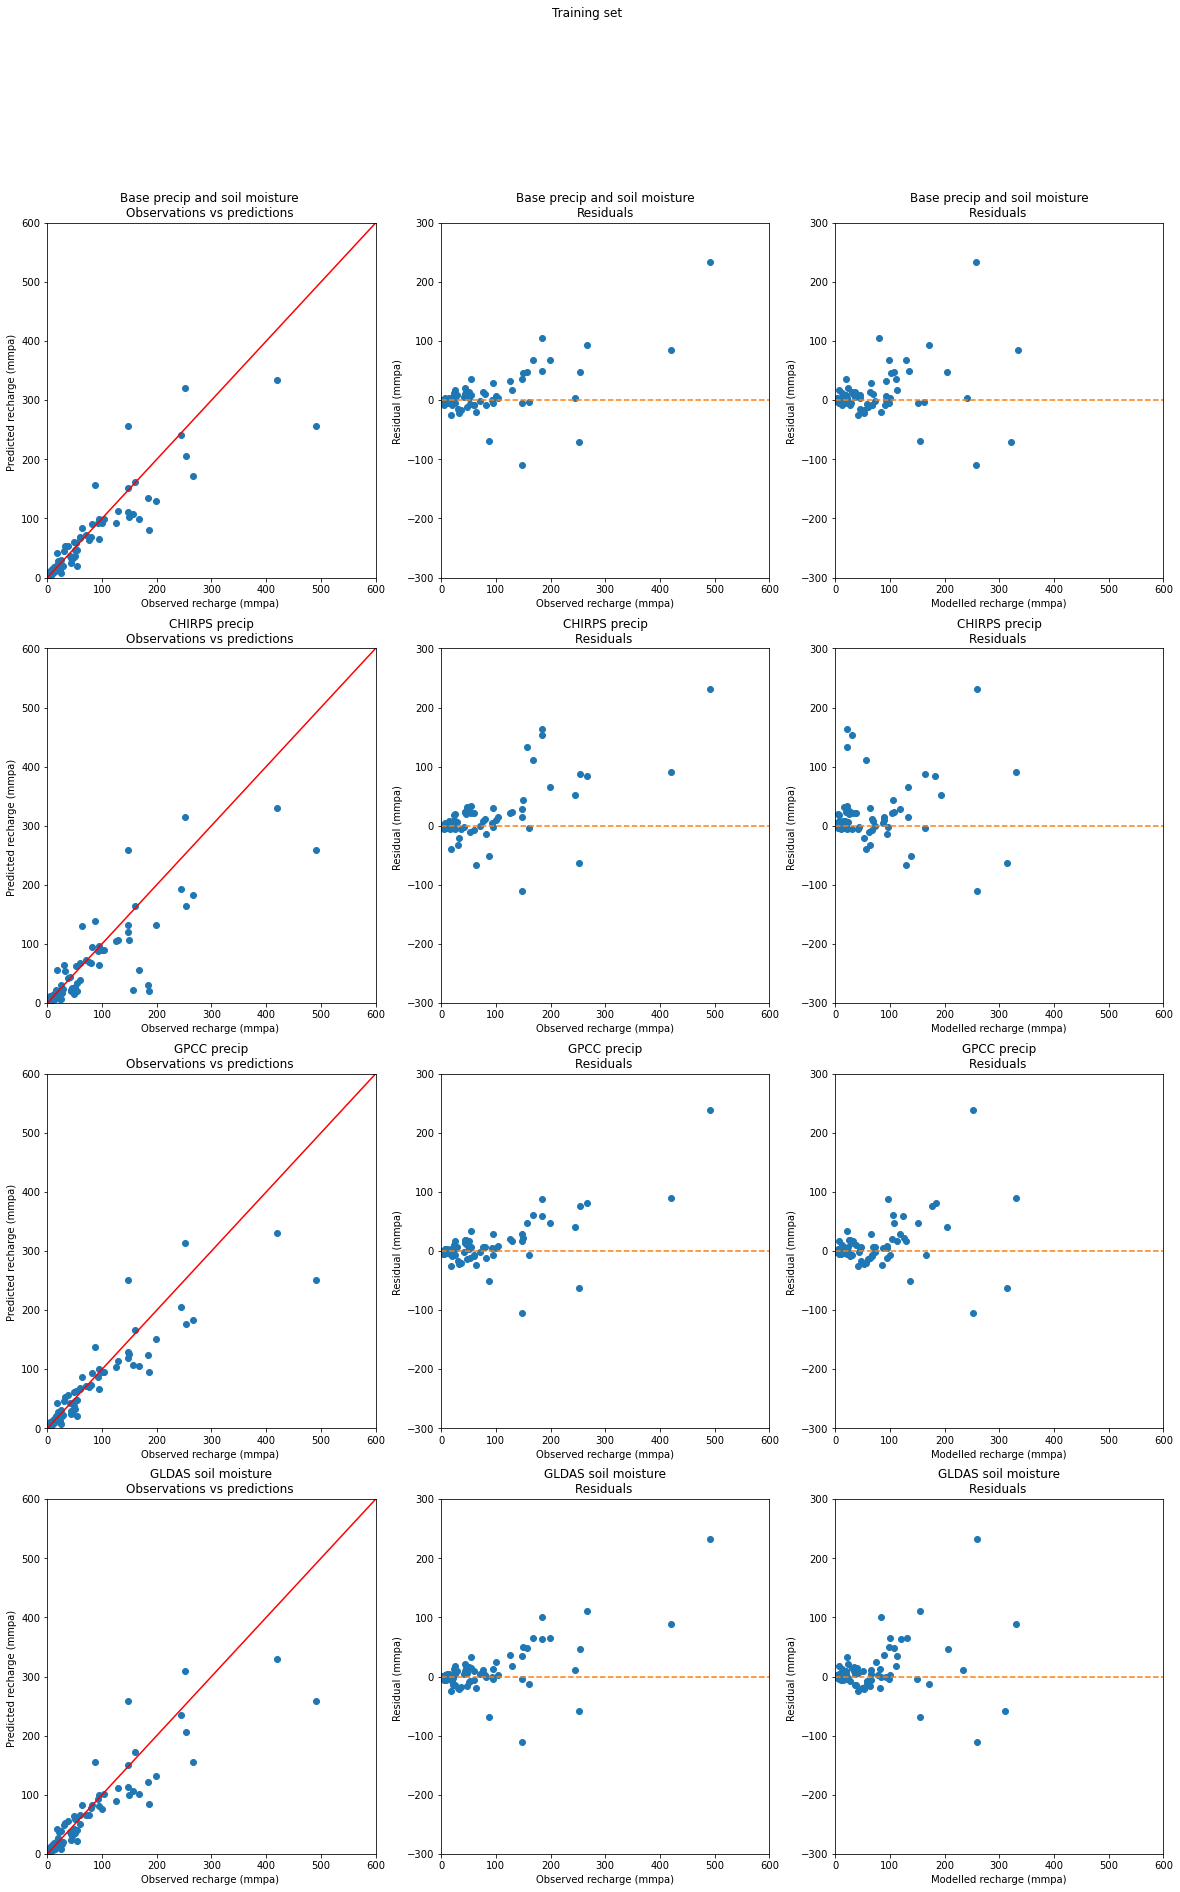

In [8]:
fig, axs = plt.subplots(4,3,figsize=(20,30))
fig.suptitle('Training set')
axs = axs.flatten()

axs[0].scatter(10**train_labels, 10**base_train_predictions)
#axs[0].plot(range(-1,4), range(-1,4), 'r')
axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Base precip and soil moisture \nObservations vs predictions ')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,600])
axs[0].set_ylim([0,600])

axs[1].plot(10**train_labels, 10**train_labels - 10**base_train_predictions,marker='o',linestyle='')
axs[1].plot(range(0,600), np.zeros((600,)), '--')
axs[1].set_title('Base precip and soil moisture\nResiduals')
axs[1].set_xlabel('Observed recharge (mmpa)')
axs[1].set_ylabel('Residual (mmpa) ')
axs[1].set_xlim([0,600])
axs[1].set_ylim([-300,300])

axs[2].plot(10**base_train_predictions, 10**train_labels - 10**base_train_predictions,marker='o',linestyle='')
axs[2].plot(range(0,600), np.zeros((600,)), '--')
axs[2].set_title('Base precip and soil moisture\nResiduals ')
axs[2].set_xlabel('Modelled recharge (mmpa)')
axs[2].set_ylabel('Residual (mmpa) ')
axs[2].set_xlim([0,600])
axs[2].set_ylim([-300,300])

axs[3].scatter(10**train_labels, 10**chirps_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('CHIRPS precip\nObservations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,600])
axs[3].set_ylim([0,600])

axs[4].plot(10**train_labels, 10**train_labels - 10**chirps_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,600), np.zeros((600,)), '--')
axs[4].set_title('CHIRPS precip\nResiduals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-300,300])

axs[5].plot(10**chirps_train_predictions, 10**train_labels - 10**chirps_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,600), np.zeros((600,)), '--')
axs[5].set_title('CHIRPS precip\nResiduals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-300,300])

axs[6].scatter(10**train_labels, 10**gpcc_train_predictions)
#axs[6].plot(range(-1,4), range(-1,4), 'r')
axs[6].plot(range(0,700), range(0,700), 'r')
axs[6].set_title('GPCC precip\nObservations vs predictions ')
axs[6].set_xlabel('Observed recharge (mmpa) ')
axs[6].set_ylabel('Predicted recharge (mmpa) ')
axs[6].set_xlim([0,600])
axs[6].set_ylim([0,600])

axs[7].plot(10**train_labels, 10**train_labels - 10**gpcc_train_predictions,marker='o',linestyle='')
axs[7].plot(range(0,600), np.zeros((600,)), '--')
axs[7].set_title('GPCC precip\nResiduals ')
axs[7].set_xlabel('Observed recharge (mmpa)')
axs[7].set_ylabel('Residual (mmpa) ')
axs[7].set_xlim([0,600])
axs[7].set_ylim([-300,300])

axs[8].plot(10**gpcc_train_predictions, 10**train_labels - 10**gpcc_train_predictions,marker='o',linestyle='')
axs[8].plot(range(0,600), np.zeros((600,)), '--')
axs[8].set_title('GPCC precip\nResiduals ')
axs[8].set_xlabel('Modelled recharge (mmpa)')
axs[8].set_ylabel('Residual (mmpa) ')
axs[8].set_xlim([0,600])
axs[8].set_ylim([-300,300])

axs[9].scatter(10**train_labels, 10**gldas_train_predictions)
#axs[9].plot(range(-1,4), range(-1,4), 'r')
axs[9].plot(range(0,700), range(0,700), 'r')
axs[9].set_title('GLDAS soil moisture\nObservations vs predictions ')
axs[9].set_xlabel('Observed recharge (mmpa) ')
axs[9].set_ylabel('Predicted recharge (mmpa) ')
axs[9].set_xlim([0,600])
axs[9].set_ylim([0,600])

axs[10].plot(10**train_labels, 10**train_labels - 10**gldas_train_predictions,marker='o',linestyle='')
axs[10].plot(range(0,600), np.zeros((600,)), '--')
axs[10].set_title('GLDAS soil moisture\nResiduals ')
axs[10].set_xlabel('Observed recharge (mmpa)')
axs[10].set_ylabel('Residual (mmpa) ')
axs[10].set_xlim([0,600])
axs[10].set_ylim([-300,300])

axs[11].plot(10**gldas_train_predictions, 10**train_labels - 10**gldas_train_predictions,marker='o',linestyle='')
axs[11].plot(range(0,600), np.zeros((600,)), '--')
axs[11].set_title('GLDAS soil moisture\nResiduals ')
axs[11].set_xlabel('Modelled recharge (mmpa)')
axs[11].set_ylabel('Residual (mmpa) ')
axs[11].set_xlim([0,600])
axs[11].set_ylim([-300,300])

In [21]:
# testing set metrics
print('=== BASE DATA ::::: Prediction of testing set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(test_labels, base_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, base_predictions))
print('Max Error:', metrics.max_error(test_labels, base_predictions))
print('R^2:', metrics.r2_score(test_labels, base_predictions))
# testing set metrics
print('=== CHIRPS DATA ::::: Prediction of testing set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(test_labels, chirps_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, chirps_predictions))
print('Max Error:', metrics.max_error(test_labels, chirps_predictions))
print('R^2:', metrics.r2_score(test_labels, chirps_predictions))
# testing set metrics
print('=== GPCC DATA ::::: Prediction of testing set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(test_labels, gpcc_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, gpcc_predictions))
print('Max Error:', metrics.max_error(test_labels, gpcc_predictions))
print('R^2:', metrics.r2_score(test_labels, gpcc_predictions))
# testing set metrics
print('=== GLDAS DATA ::::: Prediction of testing set ===')
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(test_labels, gldas_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(test_labels, gldas_predictions))
print('Max Error:', metrics.max_error(test_labels, gldas_predictions))
print('R^2:', metrics.r2_score(test_labels, gldas_predictions))

=== BASE DATA ::::: Prediction of testing set ===
Root Mean Squared Error (RMSE): 0.4072626739781574
Explained Variance Score: 0.6744918233703063
Max Error: 0.9785652614468681
R^2: 0.6693814435017533
=== CHIRPS DATA ::::: Prediction of testing set ===
Root Mean Squared Error (RMSE): 0.38409625746089404
Explained Variance Score: 0.7073572627301502
Max Error: 1.030790096805072
R^2: 0.7059249634577496
=== GPCC DATA ::::: Prediction of testing set ===
Root Mean Squared Error (RMSE): 0.39806855312170286
Explained Variance Score: 0.6851476027699415
Max Error: 1.0330840042556837
R^2: 0.6841406414077635
=== GLDAS DATA ::::: Prediction of testing set ===
Root Mean Squared Error (RMSE): 0.4213233812463611
Explained Variance Score: 0.6515172752125646
Max Error: 1.0551059724483958
R^2: 0.6461582043084141


(-300.0, 300.0)

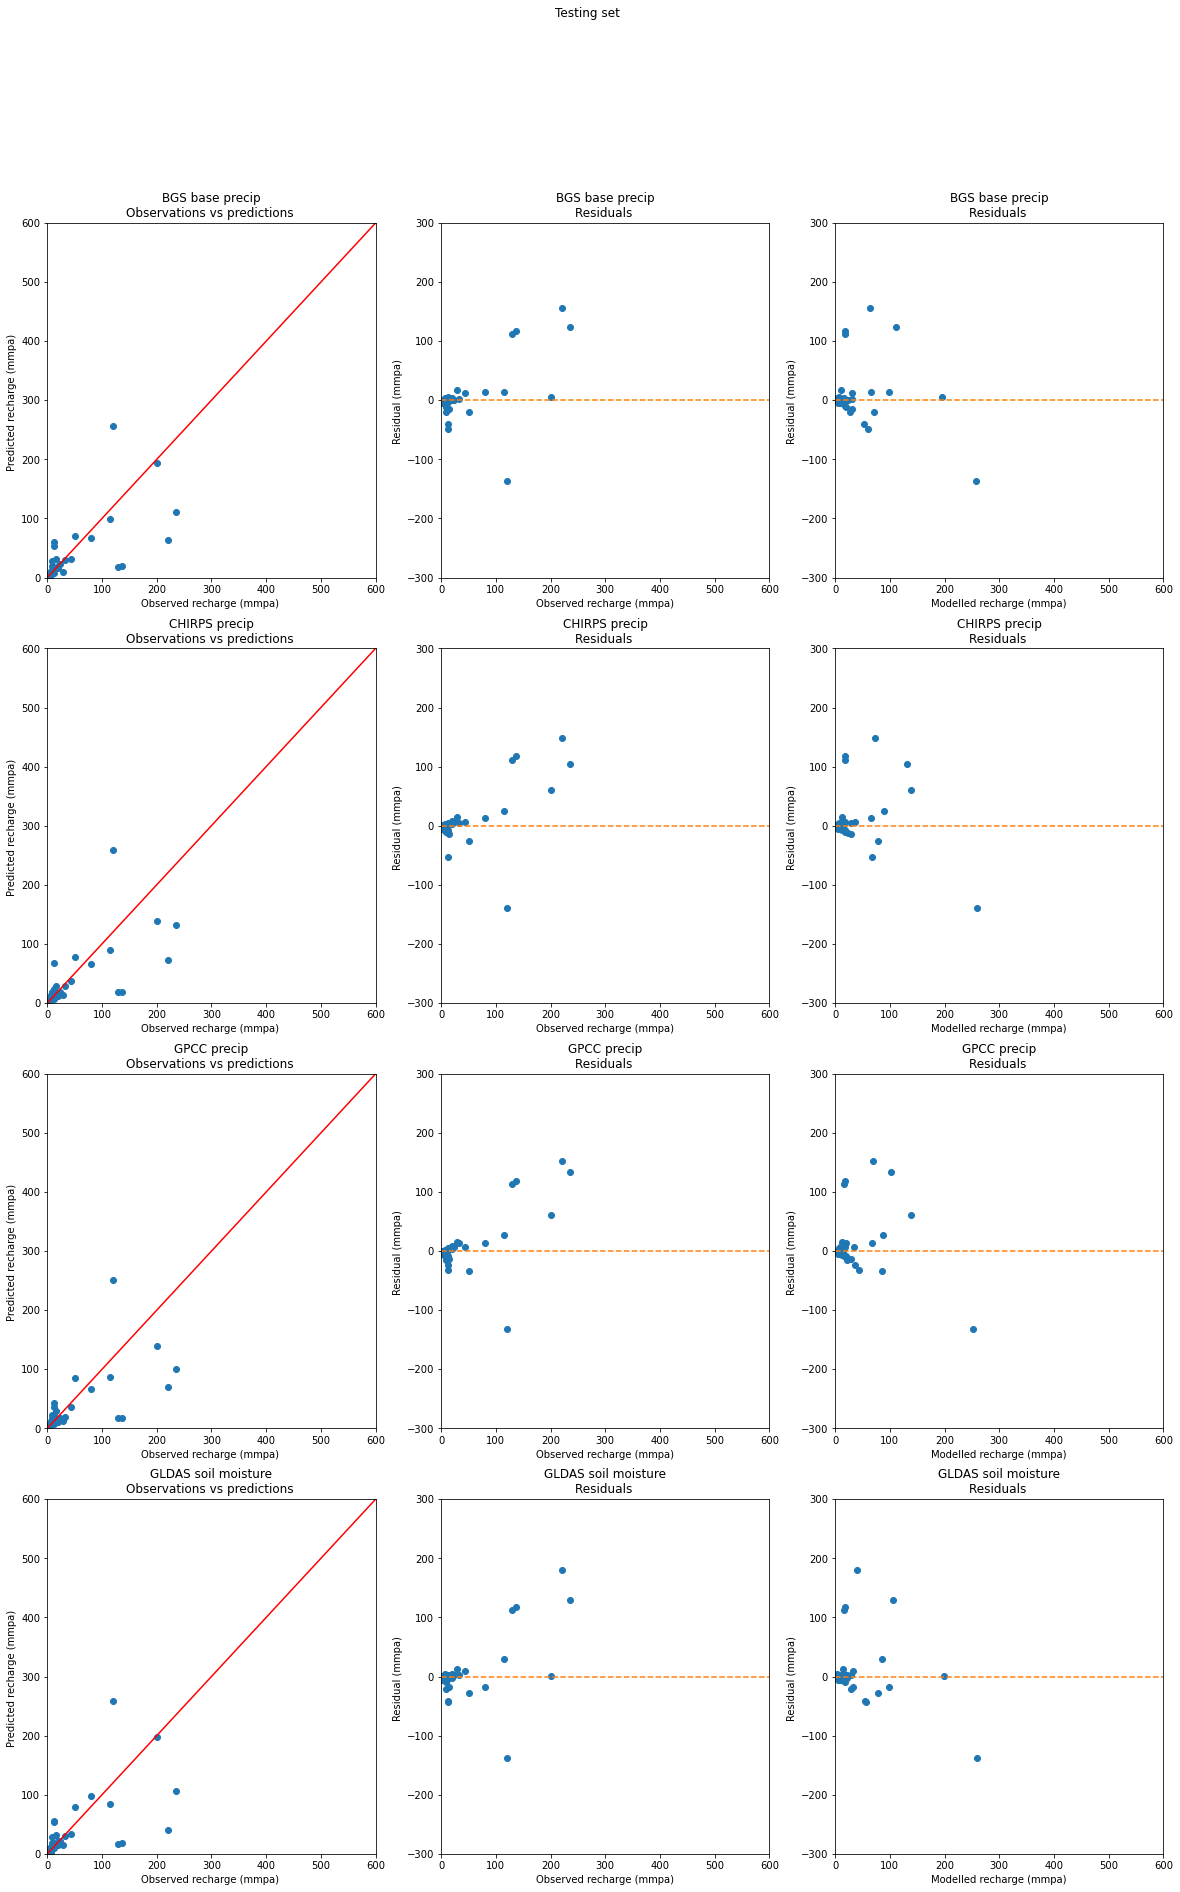

In [10]:
fig, axs = plt.subplots(4,3,figsize=(20,30))
fig.suptitle('Testing set')
axs = axs.flatten()

axs[0].scatter(10**test_labels, 10**base_predictions)
#axs[0].plot(range(-1,4), range(-1,4), 'r')
axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('BGS base precip\nObservations vs predictions ')
axs[0].set_xlabel('Observed recharge (mmpa) ')
axs[0].set_ylabel('Predicted recharge (mmpa) ')
axs[0].set_xlim([0,600])
axs[0].set_ylim([0,600])

axs[1].plot(10**test_labels, 10**test_labels - 10**base_predictions,marker='o',linestyle='')
axs[1].plot(range(0,600), np.zeros((600,)), '--')
axs[1].set_title('BGS base precip\nResiduals ')
axs[1].set_xlabel('Observed recharge (mmpa)')
axs[1].set_ylabel('Residual (mmpa) ')
axs[1].set_xlim([0,600])
axs[1].set_ylim([-300,300])

axs[2].plot(10**base_predictions, 10**test_labels - 10**base_predictions,marker='o',linestyle='')
axs[2].plot(range(0,600), np.zeros((600,)), '--')
axs[2].set_title('BGS base precip\nResiduals ')
axs[2].set_xlabel('Modelled recharge (mmpa)')
axs[2].set_ylabel('Residual (mmpa) ')
axs[2].set_xlim([0,600])
axs[2].set_ylim([-300,300])

axs[3].scatter(10**test_labels, 10**chirps_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,700), range(0,700), 'r')
axs[3].set_title('CHIRPS precip\nObservations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,600])
axs[3].set_ylim([0,600])

axs[4].plot(10**test_labels, 10**test_labels - 10**chirps_predictions,marker='o',linestyle='')
axs[4].plot(range(0,600), np.zeros((600,)), '--')
axs[4].set_title('CHIRPS precip\nResiduals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-300,300])

axs[5].plot(10**chirps_predictions, 10**test_labels - 10**chirps_predictions,marker='o',linestyle='')
axs[5].plot(range(0,600), np.zeros((600,)), '--')
axs[5].set_title('CHIRPS precip\nResiduals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-300,300])

axs[6].scatter(10**test_labels, 10**gpcc_predictions)
#axs[6].plot(range(-1,4), range(-1,4), 'r')
axs[6].plot(range(0,700), range(0,700), 'r')
axs[6].set_title('GPCC precip\nObservations vs predictions ')
axs[6].set_xlabel('Observed recharge (mmpa) ')
axs[6].set_ylabel('Predicted recharge (mmpa) ')
axs[6].set_xlim([0,600])
axs[6].set_ylim([0,600])

axs[7].plot(10**test_labels, 10**test_labels - 10**gpcc_predictions,marker='o',linestyle='')
axs[7].plot(range(0,600), np.zeros((600,)), '--')
axs[7].set_title('GPCC precip\nResiduals ')
axs[7].set_xlabel('Observed recharge (mmpa)')
axs[7].set_ylabel('Residual (mmpa) ')
axs[7].set_xlim([0,600])
axs[7].set_ylim([-300,300])

axs[8].plot(10**gpcc_predictions, 10**test_labels - 10**gpcc_predictions,marker='o',linestyle='')
axs[8].plot(range(0,600), np.zeros((600,)), '--')
axs[8].set_title('GPCC precip\nResiduals ')
axs[8].set_xlabel('Modelled recharge (mmpa)')
axs[8].set_ylabel('Residual (mmpa) ')
axs[8].set_xlim([0,600])
axs[8].set_ylim([-300,300])

axs[9].scatter(10**test_labels, 10**gldas_predictions)
#axs[9].plot(range(-1,4), range(-1,4), 'r')
axs[9].plot(range(0,700), range(0,700), 'r')
axs[9].set_title('GLDAS soil moisture\nObservations vs predictions ')
axs[9].set_xlabel('Observed recharge (mmpa) ')
axs[9].set_ylabel('Predicted recharge (mmpa) ')
axs[9].set_xlim([0,600])
axs[9].set_ylim([0,600])

axs[10].plot(10**test_labels, 10**test_labels - 10**gldas_predictions,marker='o',linestyle='')
axs[10].plot(range(0,600), np.zeros((600,)), '--')
axs[10].set_title('GLDAS soil moisture\nResiduals ')
axs[10].set_xlabel('Observed recharge (mmpa)')
axs[10].set_ylabel('Residual (mmpa) ')
axs[10].set_xlim([0,600])
axs[10].set_ylim([-300,300])

axs[11].plot(10**gldas_predictions, 10**test_labels - 10**gldas_predictions,marker='o',linestyle='')
axs[11].plot(range(0,600), np.zeros((600,)), '--')
axs[11].set_title('GLDAS soil moisture\nResiduals ')
axs[11].set_xlabel('Modelled recharge (mmpa)')
axs[11].set_ylabel('Residual (mmpa) ')
axs[11].set_xlim([0,600])
axs[11].set_ylim([-300,300])

## OBTAIN 4 RECHARGE MAPS

### Data and model preparation

In [11]:
chirps_features = np.delete(features,obj=[1,2,7], axis=1)
base_features = np.delete(features,obj=[0,1,7], axis=1)
gpcc_features = np.delete(features,obj=[0,2,7], axis=1)
gldas_features = np.delete(features,obj=[0,1,6], axis=1)

# get all coordinates of the smallest raster - workaround as rasters have slightly different shapes
coords, T0, out_shape = getAllCoordinates('Data/Low_res_data_05/LTA_AnnPrecip_Afr_05.tif')
# read rasters
pet_src = rasterio.open('Data/Low_res_data_05/LTA_AnnPET_Afr_05.tif')
ndvi_src = rasterio.open('Data/Low_res_data_05/LTA_NDVI_Afr_05.tif')
ai_src = rasterio.open('Data/Low_res_data_05/LTA_aridity_index_Afr_05.tif')
sm_fldas_src = rasterio.open('Data/Low_res_data_05/LTA_FLDAS_soil_moisture_Afr_05.tif')
sm_gldas_src = rasterio.open('Data/Precip_sensitivity_data/LTA_GLDAS_soil_moisture_Afr_05.tif')
p_cru_src = rasterio.open('Data/Low_res_data_05/LTA_AnnPrecip_Afr_05.tif')
p_chirps_src = rasterio.open('Data/Precip_sensitivity_data/LTA_CHIRPS_Afr_05.tif')
p_gpcc_src = rasterio.open('Data/Precip_sensitivity_data/LTA_GPCC_precip_Afr_05.tif')

# get raster values at 0.5x0.5 grid + flatten
pet_samples = [item for sublist in list(pet_src.sample(coords)) for item in sublist]
ndvi_samples = [item for sublist in list(ndvi_src.sample(coords)) for item in sublist]
ai_samples = [item for sublist in list(ai_src.sample(coords)) for item in sublist]
sm_fldas_samples = [item for sublist in list(sm_fldas_src.sample(coords)) for item in sublist]
sm_gldas_samples = [item for sublist in list(sm_gldas_src.sample(coords)) for item in sublist]
p_cru_samples = [item for sublist in list(p_cru_src.sample(coords)) for item in sublist]
p_chirps_samples = [item for sublist in list(p_chirps_src.sample(coords)) for item in sublist]
p_gpcc_samples = [item for sublist in list(p_gpcc_src.sample(coords)) for item in sublist]

# combine predictors in a dataframe
raw_ds_base = pd.DataFrame({'LTA_P_mmpa': p_cru_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                              'NDVI': ndvi_samples,'SM10_m3m3': sm_fldas_samples})
raw_ds_chirps = pd.DataFrame({'LTA_P_mmpa': p_chirps_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                              'NDVI': ndvi_samples,'SM10_m3m3': sm_fldas_samples})
raw_ds_gpcc = pd.DataFrame({'LTA_P_mmpa': p_gpcc_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                              'NDVI': ndvi_samples,'SM10_m3m3': sm_fldas_samples})
raw_ds_gldas = pd.DataFrame({'LTA_P_mmpa': p_cru_samples, 'LTA_PET_mm': pet_samples, 'Aridity': ai_samples, 
                              'NDVI': ndvi_samples,'SM10_kgm2': sm_gldas_samples})

# take rows with valid predictor data (land only)
filtered_ds_base = raw_ds_base[(raw_ds_base['LTA_P_mmpa'] >= -1000) & (raw_ds_base['LTA_PET_mm'] >= -1000) 
                            & (raw_ds_base['Aridity'] >= -1000) & (raw_ds_base['SM10_m3m3'] > 0) & (raw_ds_base['NDVI'] >= -1000)]
filtered_ds_chirps = raw_ds_chirps[(raw_ds_chirps['LTA_P_mmpa'] >= -1000) & (raw_ds_chirps['LTA_PET_mm'] >= -1000) 
                            & (raw_ds_chirps['Aridity'] >= -1000) & (raw_ds_chirps['SM10_m3m3'] > 0) & (raw_ds_chirps['NDVI'] >= -1000)]
filtered_ds_gpcc = raw_ds_gpcc[(raw_ds_gpcc['LTA_P_mmpa'] >= -1000) & (raw_ds_gpcc['LTA_PET_mm'] >= -1000) 
                            & (raw_ds_gpcc['Aridity'] >= -1000) & (raw_ds_gpcc['SM10_m3m3'] > 0) & (raw_ds_gpcc['NDVI'] >= -1000)]
filtered_ds_gldas = raw_ds_gldas[(raw_ds_gldas['LTA_P_mmpa'] >= -1000) & (raw_ds_gldas['LTA_PET_mm'] >= -1000) 
                            & (raw_ds_gldas['Aridity'] >= -1000) & (raw_ds_gldas['SM10_kgm2'] > 0) & (raw_ds_gldas['NDVI'] >= -1000)]

# convert dataframe to numpy array
domain_features_base = np.array(filtered_ds_base)
domain_features_chirps = np.array(filtered_ds_chirps)
domain_features_gpcc = np.array(filtered_ds_gpcc)
domain_features_gldas = np.array(filtered_ds_gldas)

# keep params minimal
params = {'n_estimators': 2000}

# apply random forest
# instantiate model
final_rf_base = RandomForestRegressor(**params, oob_score=True)
final_rf_chrips = RandomForestRegressor(**params, oob_score=True)
final_rf_gpcc = RandomForestRegressor(**params, oob_score=True)
final_rf_gldas = RandomForestRegressor(**params, oob_score=True)

### Model training and prediction

In [12]:
# train the model on entire BGS dataset
final_rf_base.fit(base_features[:,:-1], labels)
final_rf_chrips.fit(chirps_features[:,:-1], labels)
final_rf_gpcc.fit(gpcc_features[:,:-1], labels)
final_rf_gldas.fit(gldas_features[:,:-1], labels)

# use the forest's predict method on the whole domain
pred_recharge_base = final_rf_base.predict(domain_features_base)
pred_recharge_chirps = final_rf_chrips.predict(domain_features_chirps)
pred_recharge_gpcc = final_rf_gpcc.predict(domain_features_gpcc)
pred_recharge_gldas = final_rf_gldas.predict(domain_features_gldas)

# apply to training set again
train_predictions_base = final_rf_base.predict(base_features[:,:-1])
train_predictions_chirps = final_rf_chrips.predict(chirps_features[:,:-1])
train_predictions_gpcc = final_rf_gpcc.predict(gpcc_features[:,:-1])
train_predictions_gldas = final_rf_gldas.predict(gldas_features[:,:-1])

### Save recharge raster

In [22]:
# merge with the features dataframe and back transform
filtered_ds_base['pred_recharge_mmpa'] = 10**pred_recharge_base
filtered_ds_chirps['pred_recharge_mmpa'] = 10**pred_recharge_chirps
filtered_ds_gpcc['pred_recharge_mmpa'] = 10**pred_recharge_gpcc
filtered_ds_gldas['pred_recharge_mmpa'] = 10**pred_recharge_gldas

# fill gaps in the dataframe - revert to 0.5x0.5 grid
reindx_ds_base = filtered_ds_chirps.reindex(range(len(raw_ds_base)), fill_value=-9999)
reindx_ds_chirps = filtered_ds_chirps.reindex(range(len(raw_ds_chirps)), fill_value=-9999)
reindx_ds_gpcc = filtered_ds_gpcc.reindex(range(len(raw_ds_gpcc)), fill_value=-9999)
reindx_ds_gldas = filtered_ds_gldas.reindex(range(len(raw_ds_gldas)), fill_value=-9999)

recharge_grid_base = np.array(reindx_ds_base['pred_recharge_mmpa']).reshape(out_shape)
recharge_grid_chirps = np.array(reindx_ds_chirps['pred_recharge_mmpa']).reshape(out_shape)
recharge_grid_gpcc = np.array(reindx_ds_gpcc['pred_recharge_mmpa']).reshape(out_shape)
recharge_grid_gldas = np.array(reindx_ds_gldas['pred_recharge_mmpa']).reshape(out_shape)

# attempt to save to a raster
# config
out_meta = {'driver': 'GTiff', "dtype": 'float32', "height": recharge_grid_chirps.shape[0], "width": recharge_grid_chirps.shape[1],
            "count": 1, "transform": T0, 'nodata': -9999, 'crs': rasterio.crs.CRS({"init": "epsg:4326"})}

# save
with rasterio.open("Data/Precip_sensitivity_data/RF_recharge_BASE.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid_base[np.newaxis, :, :])
with rasterio.open("Data/Precip_sensitivity_data/RF_recharge_CHIRPS.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid_chirps[np.newaxis, :, :])
with rasterio.open("Data/Precip_sensitivity_data/RF_recharge_GPCC.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid_gpcc[np.newaxis, :, :])
with rasterio.open("Data/Precip_sensitivity_data/RF_recharge_GLDAS.tif", "w", **out_meta) as dest:
    dest.write(recharge_grid_gldas[np.newaxis, :, :])

# VISUALISE

In [14]:
import geemap
import ee
ee.Initialize()

# center over Africa
Map = geemap.Map(center=[0,40], zoom=2)

rf_recharge_vis_params = {
    'min': 0,'max': 300, 
    'bands':'rf_recharge', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}

In [15]:
# add base recharge
ee_rf_recharge_base = ee.Image('users/pazolka/RF_recharge_BASE').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_base, rf_recharge_vis_params, 'RF recharge BASE', shown=False)
# add chirps recharge
ee_rf_recharge_chirps = ee.Image('users/pazolka/RF_recharge_CHIRPS').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_chirps, rf_recharge_vis_params, 'RF recharge CHIRPS', shown=False)
# add gpcc recharge
ee_rf_recharge_gpcc = ee.Image('users/pazolka/RF_recharge_GPCC').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_gpcc, rf_recharge_vis_params, 'RF recharge GPCC', shown=False)
# add gldas recharge
ee_rf_recharge_gldas = ee.Image('users/pazolka/RF_recharge_GLDAS').rename('rf_recharge')
Map.addLayer(ee_rf_recharge_gldas, rf_recharge_vis_params, 'RF recharge GLDAS', shown=False)
# fix for clean colorbar
rf_recharge_vis_params['bands'] = 'RF recharge (mmpa)'
Map.add_colorbar(rf_recharge_vis_params)

In [16]:
# check spatiall differences
diff_recharge_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge', 'palette': ['red', 'yellow', 'blue']
}
# base - chirps
ee_diff_recharge_chirps = ee_rf_recharge_chirps.subtract(ee_rf_recharge_base).rename('diff_recharge')
Map.addLayer(ee_diff_recharge_chirps, diff_recharge_vis_params, 'diff recharge chirps', shown=False)


diff_recharge_rel_vis_params = {
    'min': -100,'max': 100, 
    'bands':'diff_recharge_rel', 'palette': ['red', 'pink', 'yellow', 'lightgreen', 'green', 'lightblue', 'blue']
}

# base - gpcc
ee_diff_recharge_gpcc = ee_rf_recharge_gpcc.subtract(ee_rf_recharge_base).rename('diff_recharge')
Map.addLayer(ee_diff_recharge_gpcc, diff_recharge_vis_params, 'diff recharge gpcc', shown=False)

# base - chirps rel
ee_diff_recharge_rel_chirps = ee_diff_recharge_chirps.divide(ee_rf_recharge_base).multiply(100).rename('diff_recharge_rel')
Map.addLayer(ee_diff_recharge_rel_chirps, diff_recharge_rel_vis_params, 'diff recharge (rel %) chirps', shown=False)

# base - gpcc rel
ee_diff_recharge_rel_gpcc = ee_diff_recharge_gpcc.divide(ee_rf_recharge_base).multiply(100).rename('diff_recharge_rel')
Map.addLayer(ee_diff_recharge_rel_gpcc, diff_recharge_rel_vis_params, 'diff recharge (rel %) gpcc', shown=False)

# base - gldas
ee_diff_recharge_gldas = ee_rf_recharge_gldas.subtract(ee_rf_recharge_base).rename('diff_recharge')
Map.addLayer(ee_diff_recharge_gldas, diff_recharge_vis_params, 'diff recharge gldas', shown=False)

# base - gldas rel
ee_diff_recharge_rel_gldas = ee_diff_recharge_gldas.divide(ee_rf_recharge_base).multiply(100).rename('diff_recharge_rel')
Map.addLayer(ee_diff_recharge_rel_gldas, diff_recharge_rel_vis_params, 'diff recharge (rel %) gldas', shown=False)

In [17]:
# fix for clean colorbar
diff_recharge_vis_params['bands'] = 'RF2 - base recharge (mmpa)'
Map.add_colorbar(diff_recharge_vis_params, label="RF2 - base")
# fix for clean colorbar
diff_recharge_rel_vis_params['bands'] = '(RF2-base)/base (%)'
Map.add_colorbar(diff_recharge_rel_vis_params, label="(RF2-base)/base * 100%")

In [18]:
Map

Map(center=[0, 40], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [19]:
Map.add_shapefile("Data/Africa_continent_shape.shp", style={"weight": 2, 'fill':False}, fill_colors=['white'], info_mode='on_hover')